In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "apple",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7771 files belonging to 4 classes.


In [4]:
classes_names=dataset.class_names
classes_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [5]:
# we are visualizing our data 

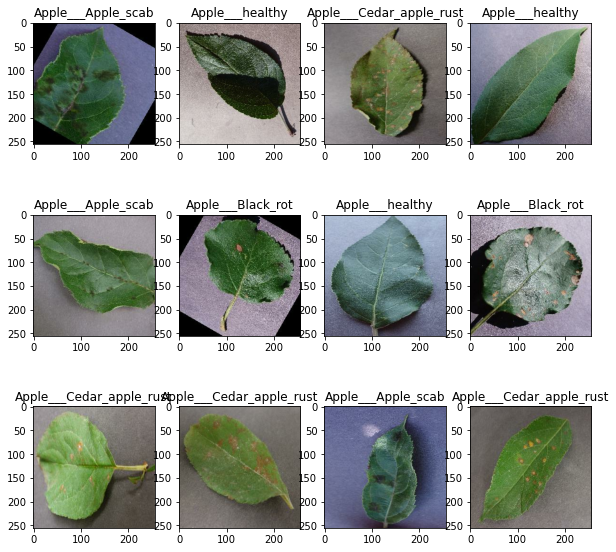

In [6]:
plt.figure(figsize=(10,10))
for x,y in dataset.take(1):
    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.imshow(x[i].numpy().astype('uint8'))
      plt.title(classes_names[y[i]])
      


# Now we split the dataset 

In [7]:
train_size = 0.8
len(dataset)*train_size

194.4

In [8]:
train_ds=dataset.take(194) # this is the train dataset 
len(train_ds)

194

In [9]:
test_ds = dataset.skip(194)
len(test_ds)

49

In [10]:
val_size=0.1 # we are going to create validation dataset 
len(dataset)*val_size

24.3

In [11]:
val_ds=dataset.take(24) # this is validation dataset 
len(val_ds)

24

In [12]:
test_ds=test_ds.skip(24)  # this is test dataset
len(test_ds)

25

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

194

In [16]:
len(val_ds)

24

In [17]:
len(test_ds)

25

# Here we prefetch , cache and shuffle data 

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
''''Creating a Layer for Resizing and Normalization Before we feed our images to network, 
we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize 
the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training
as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't 
need to but this will be useful when we are done with the training and start using the model for predictions
. At that time somone can supply an image that is not (256,256) and this layer will resize it'''

"'Creating a Layer for Resizing and Normalization Before we feed our images to network, \nwe should be resizing it to the desired size. Moreover, to improve model performance, we should normalize \nthe image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training\nas well as inference. Hence we can add that as a layer in our Sequential Model.\n\nYou might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't \nneed to but this will be useful when we are done with the training and start using the model for predictions\n. At that time somone can supply an image that is not (256,256) and this layer will resize it"

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Here we build the Actual Model 

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    # cnn network
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # ann network
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
194/194 [==============================] - 317s 2s/step - loss: 0.8066 - accuracy: 0.6579 - val_loss: 0.5966 - val_accuracy: 0.7578
Epoch 2/30
194/194 [==============================] - 871s 5s/step - loss: 0.4579 - accuracy: 0.8228 - val_loss: 0.3653 - val_accuracy: 0.8607
Epoch 3/30
194/194 [==============================] - 269s 1s/step - loss: 0.3257 - accuracy: 0.8780 - val_loss: 0.3485 - val_accuracy: 0.8698
Epoch 4/30
194/194 [==============================] - 285s 1s/step - loss: 0.2313 - accuracy: 0.9121 - val_loss: 0.2480 - val_accuracy: 0.9010
Epoch 5/30
194/194 [==============================] - 278s 1s/step - loss: 0.1726 - accuracy: 0.9371 - val_loss: 0.0971 - val_accuracy: 0.9674
Epoch 6/30
194/194 [==============================] - 274s 1s/step - loss: 0.1295 - accuracy: 0.9545 - val_loss: 0.0830 - val_accuracy: 0.9766
Epoch 7/30
194/194 [==============================] - 276s 1s/step - loss: 0.1069 - accuracy: 0.9597 - val_loss: 0.0827 - val_accuracy: 0.9609

In [35]:
# We have trained our model succesfully !!!!

In [26]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 32s 347ms/step - loss: 0.0448 - accuracy: 0.9836


In [36]:
# we predict for a single datapoint

first image to predict
actual label: Apple___Apple_scab
1/1 [==============================] - 1s 508ms/step
predicted label: Apple___Apple_scab


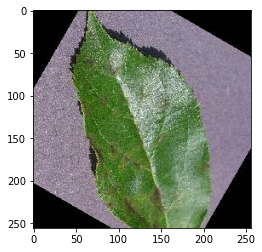

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes_names[np.argmax(batch_prediction[0])])

In [37]:
# we predict for multiple datapoints 

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


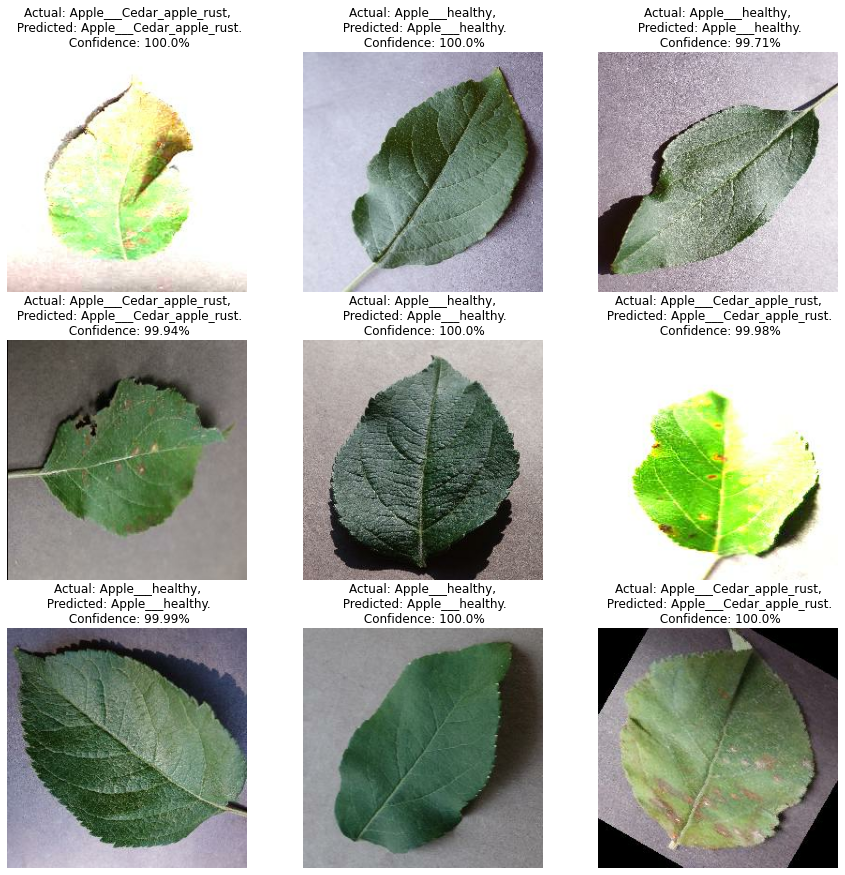

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
# we save our model or say export model to models folder

In [34]:
model.save("models/first_model.h5")

# We have succesfully built and exported our model !!!!!